In [1]:
%matplotlib inline
if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("/data/shared/Software/"))
from CMS_SURF_2016.utils.archiving import *
from CMS_SURF_2016.layers.slice import Slice
from CMS_SURF_2016.layers.lorentz import Lorentz
from keras.utils.visualize_util import plot
from IPython.display import Image, display
from CMS_SURF_2016.utils.colors import colors_contrasting
from CMS_SURF_2016.utils.analysistools import *
from CMS_SURF_2016.utils.plot import *
from CMS_SURF_2016.utils.metrics import *
import numpy as np
from CMS_SURF_2016.utils.plot import plot_history, print_accuracy_m
archive_dir = "/data/shared/Delphes/keras_archive/"

#def sortTrialsOn(lst):
    

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
trials = get_trials_by_name("LSTM", archive_dir)
#trials = findWithMetrics(trials, {"useObjTypeColumn" : True})
trials = [t for t in trials if t.is_complete()]
for trial in trials:
    trial.summary(showTraining=False,showValidation=False, showFit=False, showCompilation=False)
print("TotalNumber of Trials:", len(trials)) 

--------------------------------------------------
TRIAL SUMMARY (516d1cb7a9bb67e9b60a28206fa3cbf60ed8dad5)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 5:06:43, fit_cycles = 1
        test_acc = 0.8074, val_acc = 0.8217, test_loss = 0.8132
        num_train = 225000, num_validation = 60000, num_test = 60000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'ttbar', u'wjet', u'qcd'], lstm_dropout = 0.0, patience = 10, query = PT_ET > 1.0, sort_on = Eta
--------------------------------------------------
--------------------------------------------------
TRIAL SUMMARY (38636eec5fe2b34fcda20457661e00e984f549ce)
    Record_Info:
        name = LSTM, elapse_time = 1:18:12, fit_cycles = 1
        test_acc = 0.7432, val_acc = 0.7933, test_loss = 0.8496
        num_train = 150000, num_validation = 30000, num_test = 30000
        activation = tanh, depth = 1, dropout = 0.0, lables = [u'ttbar', u'wjet', u'qcd'], lstm_dropout = 0.0, patience = 6, query = PT_ET 

In [3]:
trials = findWithMetrics(trials, {"useObjTypeColumn" : True})
print_by_labels(trials, 4)

#plot_history([("Fully connected:", trials[0].get_history())], plotLoss=False)




 Classification: ('ttbar', 'wjet', 'qcd') 'Top 4 trials'
--------------------------------------------------
TRIAL SUMMARY (5190ddedf36c93e816c092cd73fd676bc3fca05c)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 4:13:28, fit_cycles = 1
        test_acc = 0.8970, val_acc = 0.9005, test_loss = 0.2380
        num_train = 225000, num_validation = 60000, num_test = 60000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'ttbar', u'wjet', u'qcd'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = Phi, useObjTypeColumn = True, val_acc_error = 0.000971000168372
--------------------------------------------------
--------------------------------------------------
TRIAL SUMMARY (40ba6f6c372697218128b9493834451ae739bf3c)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 4:13:20, fit_cycles = 1
        test_acc = 0.8992, val_acc = 0.8992, test_loss = 0.2320
        num_train = 225000, num_validation = 60000, num_test = 60000
      

In [66]:
t = findWithMetrics(trials, {"labels" : [u'ttbar', u'wjet', u'qcd'], 'sort_on' : "Phi"})
t[0].summary(showCompilation=True, showFit=True)

--------------------------------------------------
TRIAL SUMMARY (5190ddedf36c93e816c092cd73fd676bc3fca05c)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 4:13:28, fit_cycles = 1
        test_acc = 0.8970, val_acc = 0.9005, test_loss = 0.2380
        num_train = 225000, num_validation = 60000, num_test = 60000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'ttbar', u'wjet', u'qcd'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = Phi, useObjTypeColumn = True, val_acc_error = 0.000971000168372
    Compilation:
        optimizer=rmsprop, loss=binary_crossentropy, metrics=[u'accuracy']
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


--------------------------------------------------
TRIAL SUMMARY (40ba6f6c372697218128b9493834451ae739bf3c)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 4:13:20, fit_cycles = 1
        test_acc = 0.8992, val_acc = 0.8992, test_loss = 0.2320
        num_train = 225000, num_validation = 60000, num_test = 60000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'ttbar', u'wjet', u'qcd'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = Eta, useObjTypeColumn = True, val_acc_error = 0.000979855942508
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


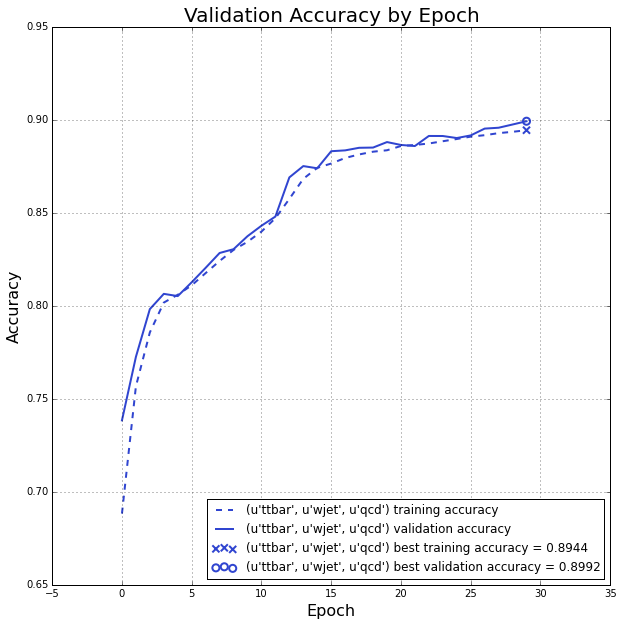

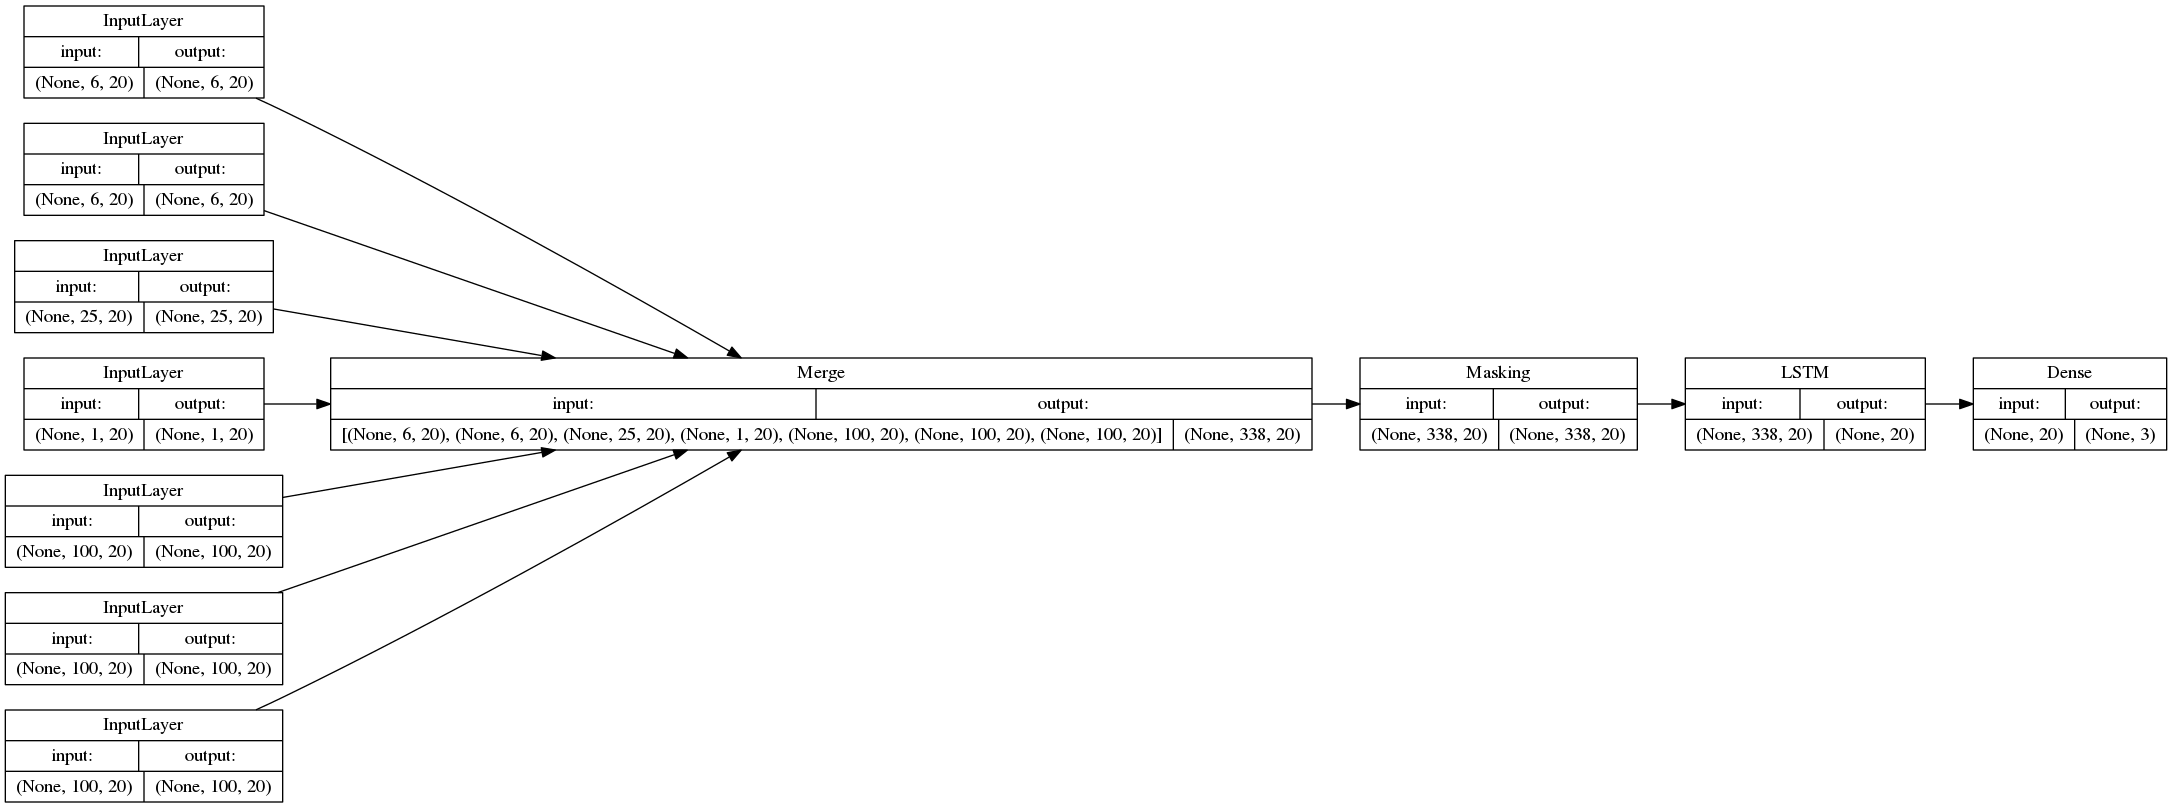

--------------------------------------------------
TRIAL SUMMARY (8eca5af4c8de1197cf0f4f11fac47c9c09f7e4e9)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 3:56:41, fit_cycles = 1
        test_acc = 0.9736, val_acc = 0.9755, test_loss = 0.0764
        num_train = 150000, num_validation = 40000, num_test = 40000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'ttbar', u'wjet'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = Phi, useObjTypeColumn = True, val_acc_error = 0.000785590445057
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


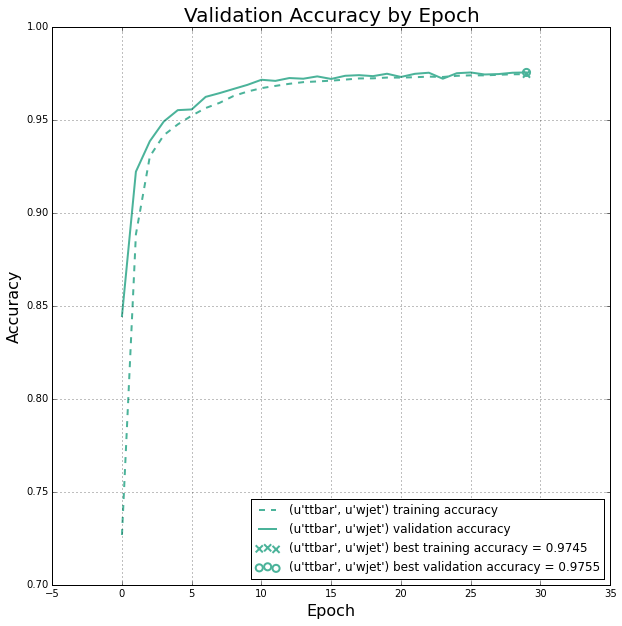

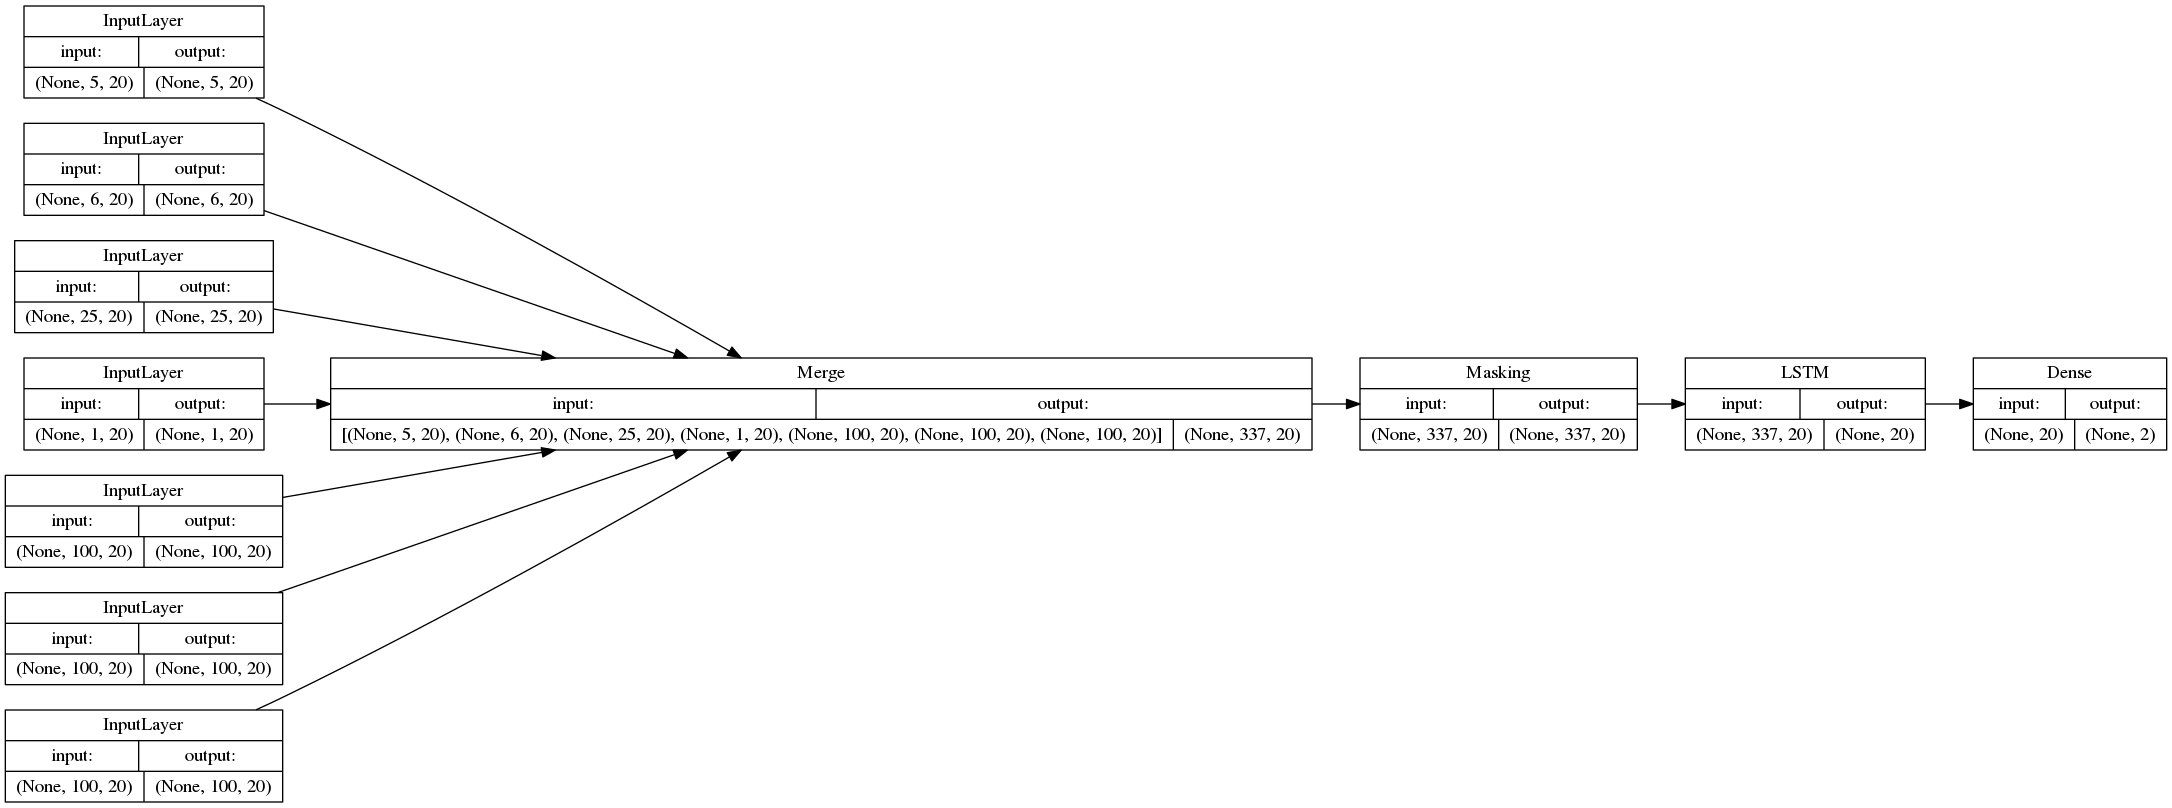

--------------------------------------------------
TRIAL SUMMARY (5190ddedf36c93e816c092cd73fd676bc3fca05c)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 4:13:28, fit_cycles = 1
        test_acc = 0.8970, val_acc = 0.9005, test_loss = 0.2380
        num_train = 225000, num_validation = 60000, num_test = 60000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'ttbar', u'wjet', u'qcd'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = Phi, useObjTypeColumn = True, val_acc_error = 0.000971000168372
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


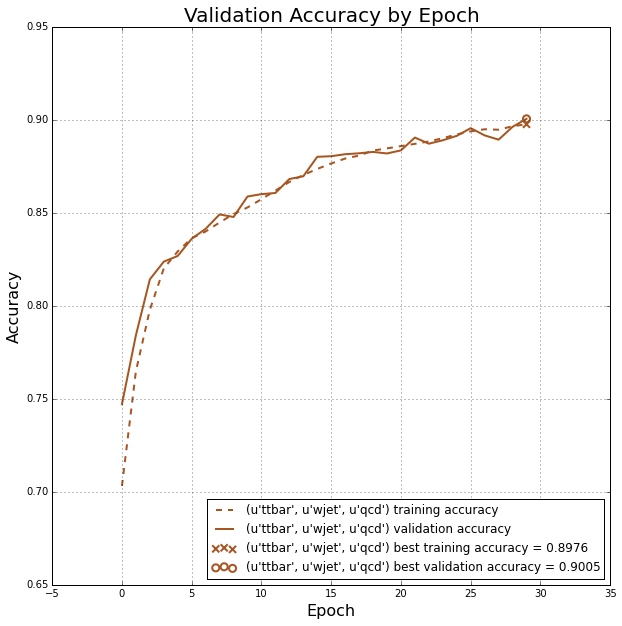

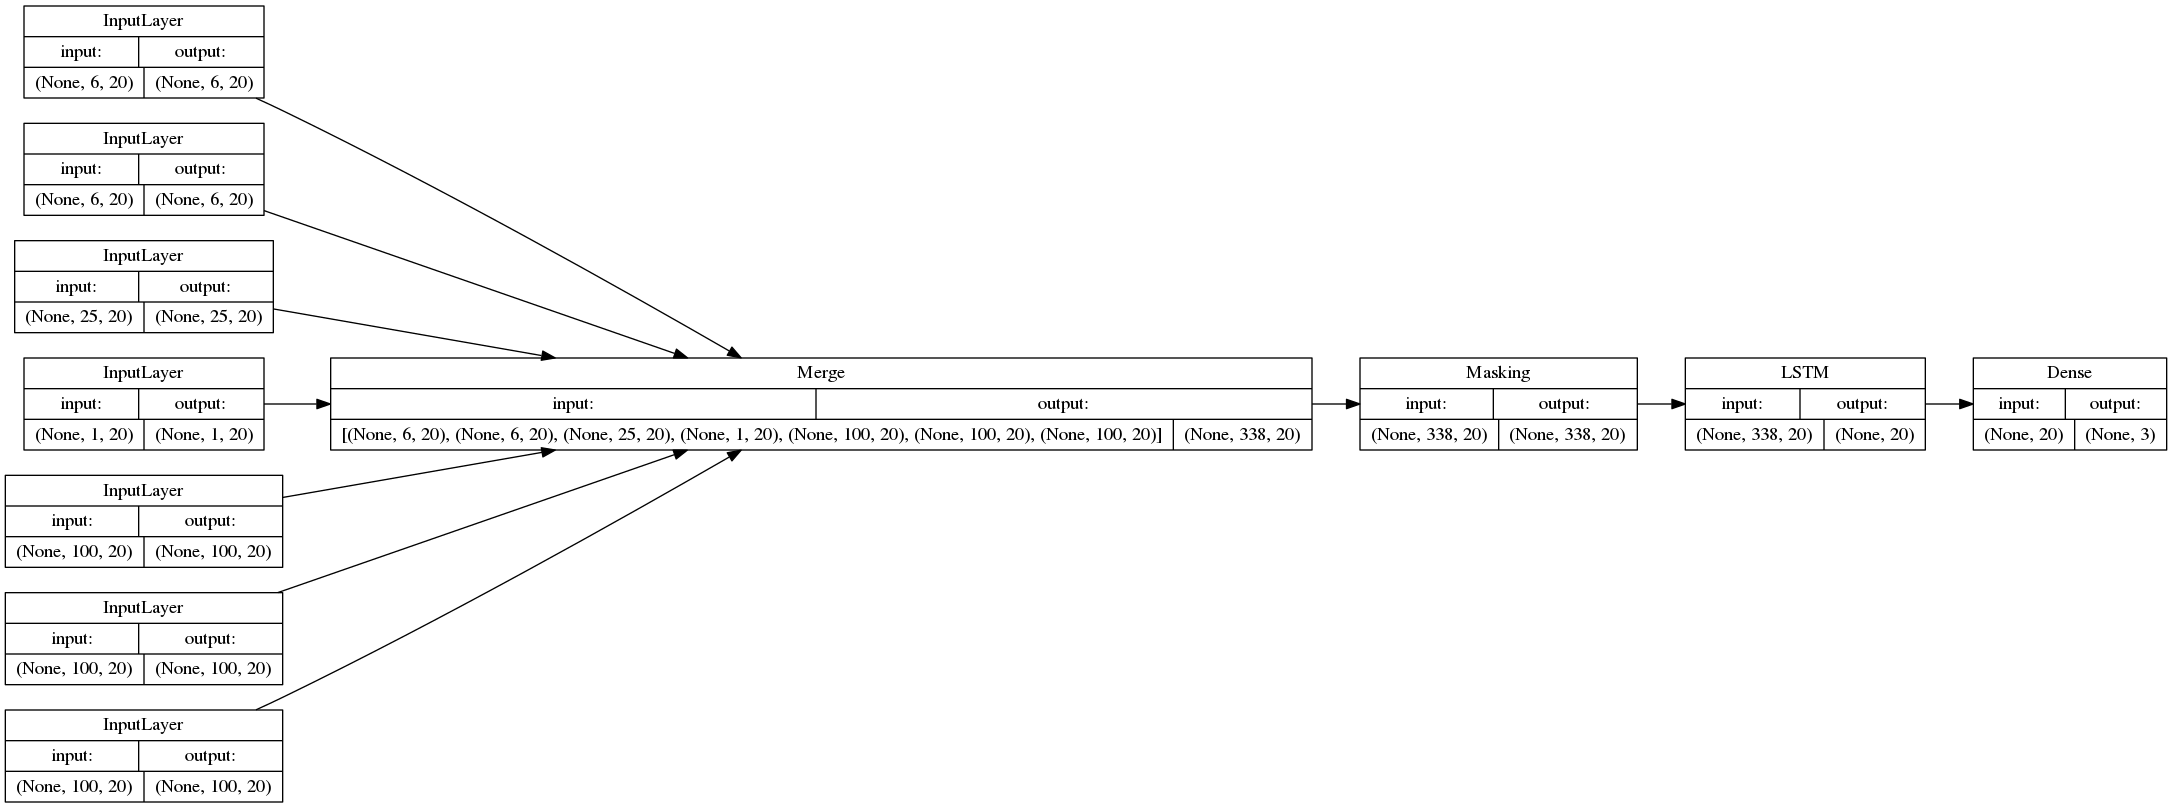

--------------------------------------------------
TRIAL SUMMARY (331e96fce3db9a6d170523b23bec36427d407b1a)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 2:49:09, fit_cycles = 1
        test_acc = 0.7944, val_acc = 0.7998, test_loss = 0.4426
        num_train = 150000, num_validation = 40000, num_test = 40000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'qcd', u'ttbar'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = Phi, useObjTypeColumn = True, val_acc_ = 0.794465641674, val_acc_error = 0.00214389985199
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


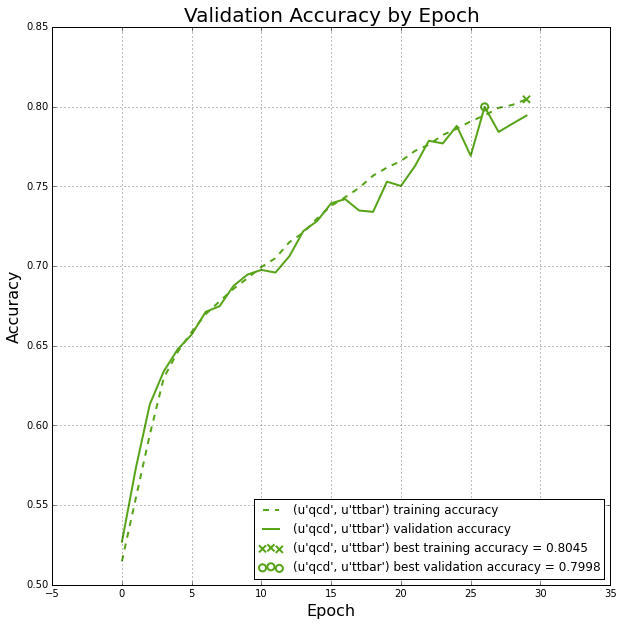

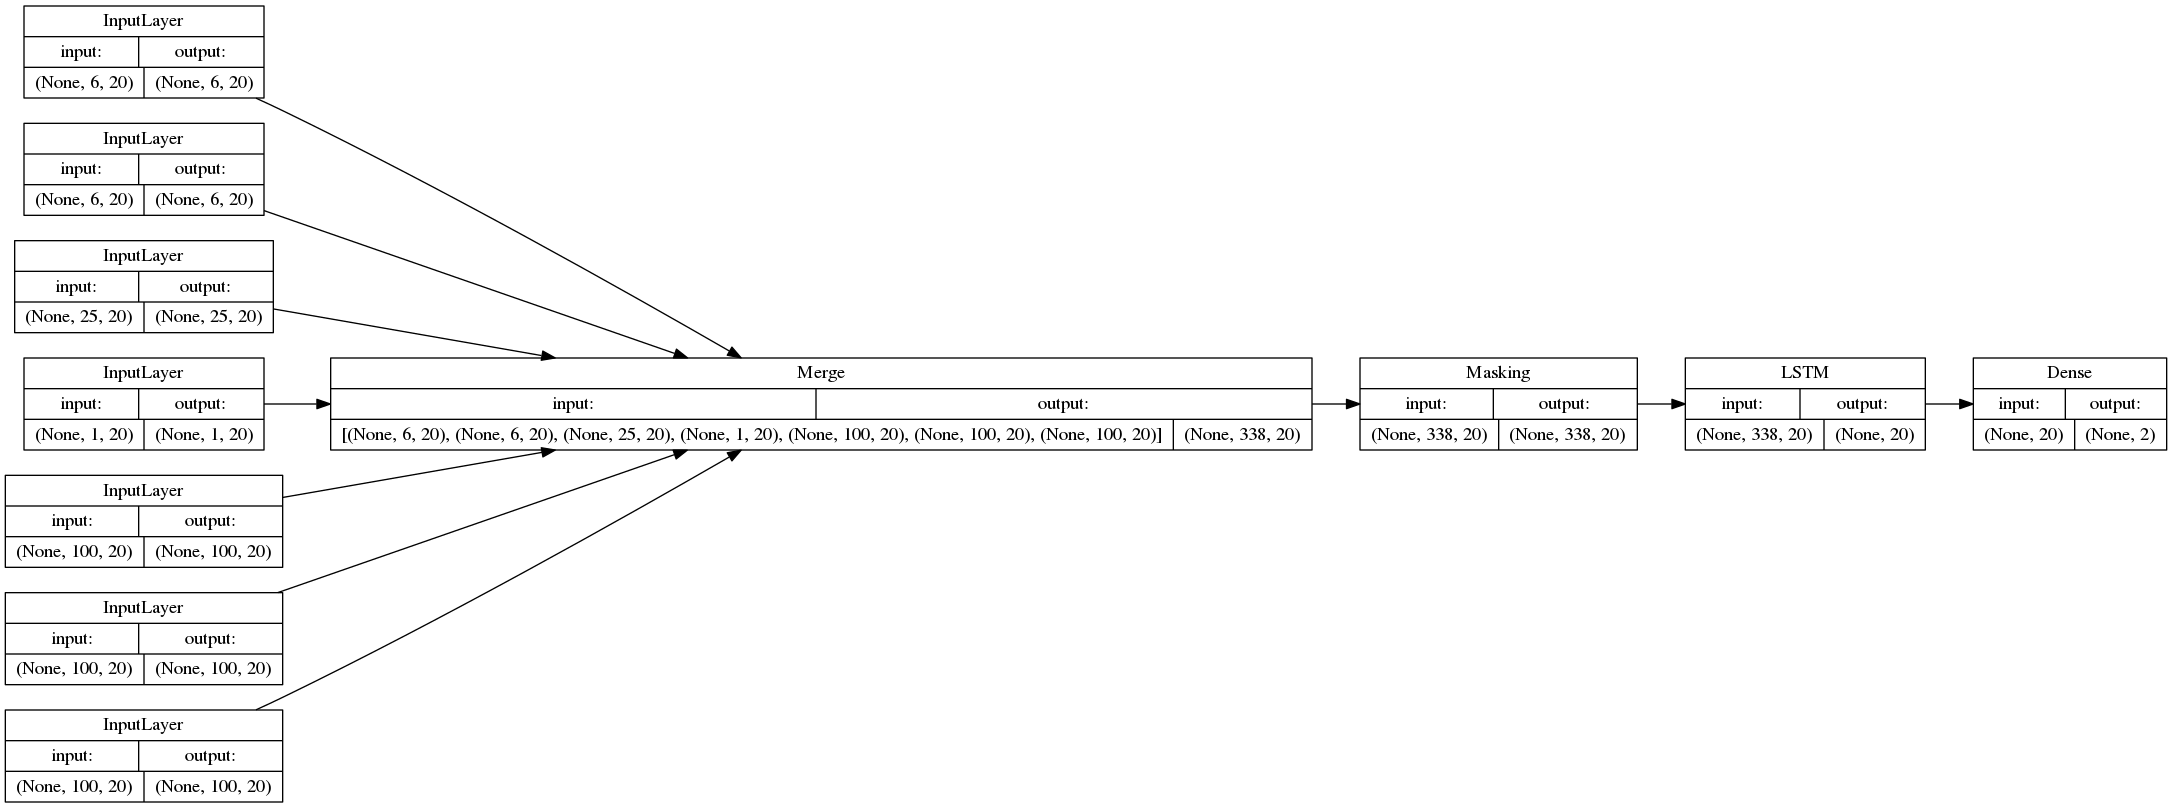

--------------------------------------------------
TRIAL SUMMARY (940f70de101c53c00d36abe48c5cc722825a4137)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 3:48:01, fit_cycles = 1
        test_acc = 0.9658, val_acc = 0.9665, test_loss = 0.1099
        num_train = 150000, num_validation = 40000, num_test = 40000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'ttbar', u'wjet'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = PT_ET, useObjTypeColumn = True, val_acc_error = 0.000909543319219
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


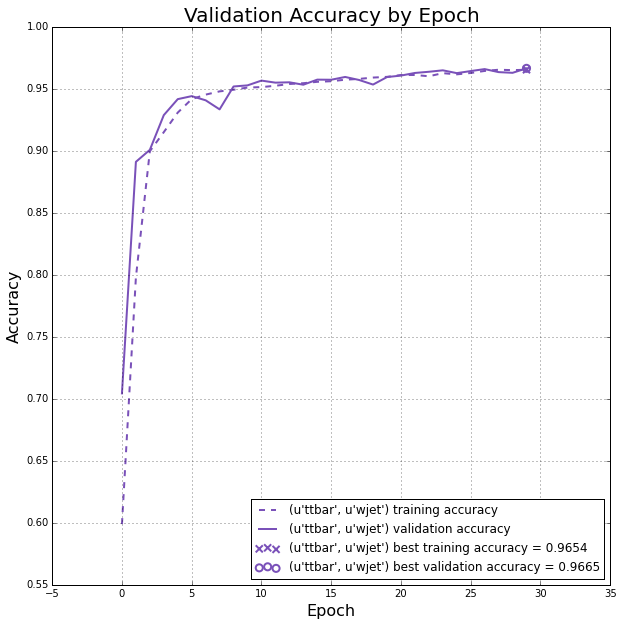

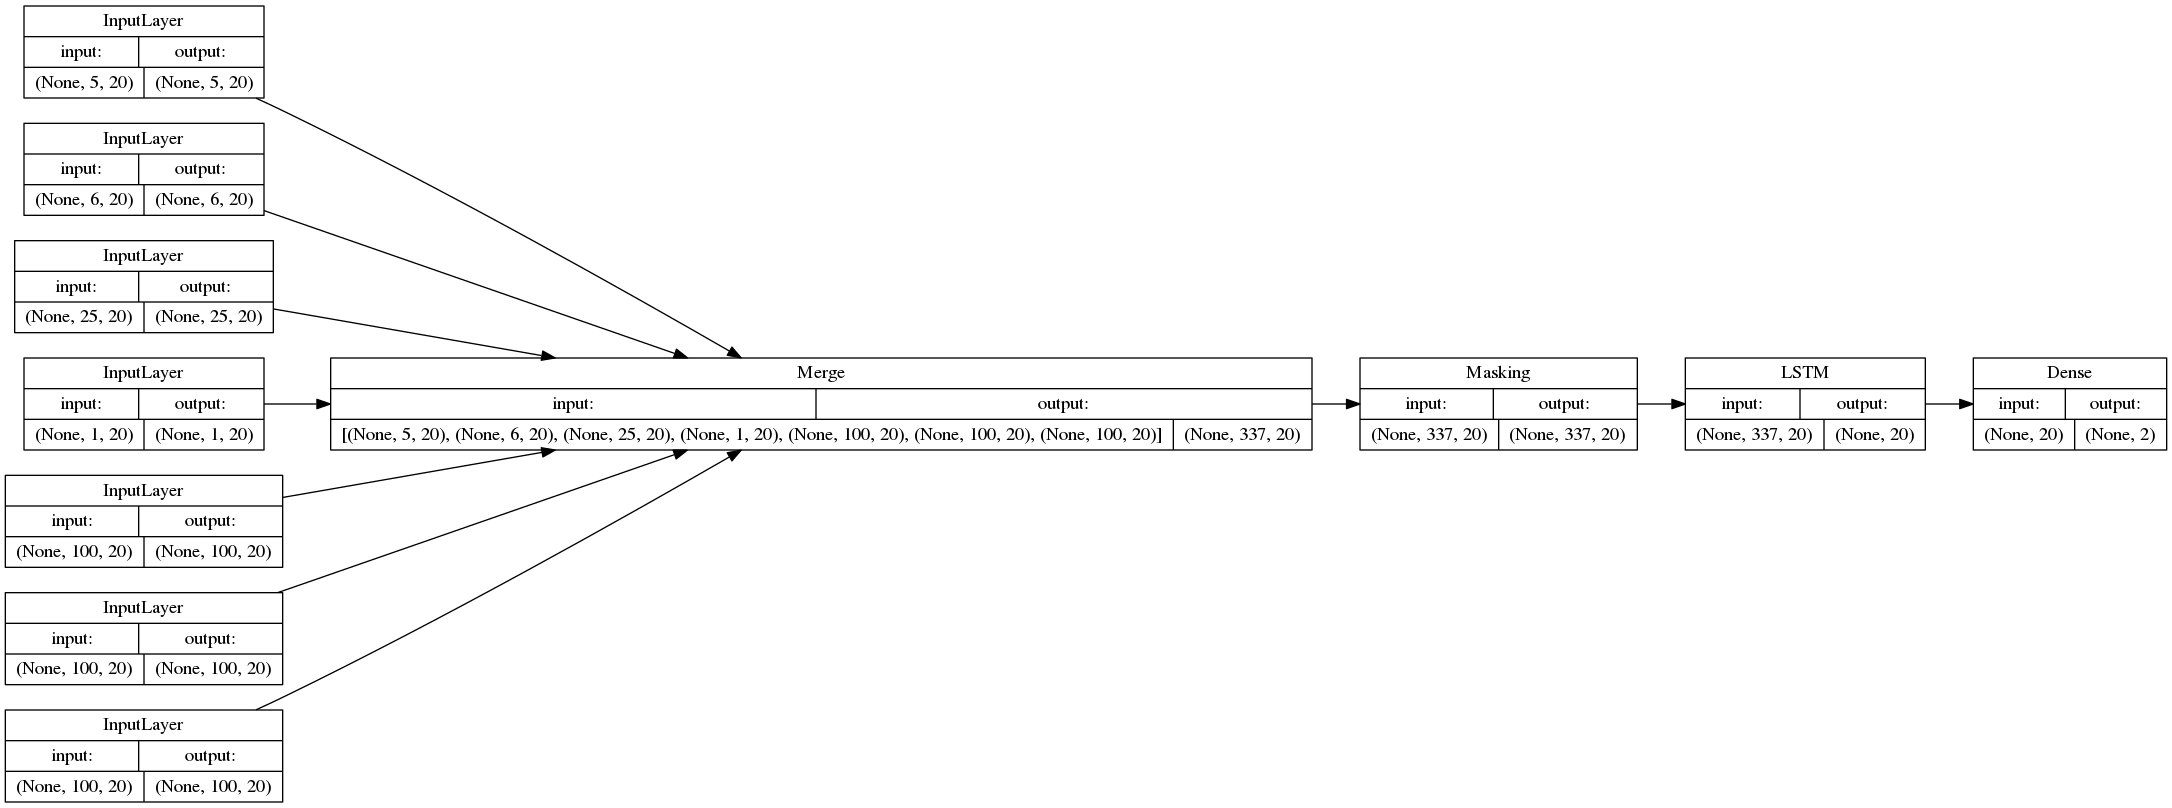

--------------------------------------------------
TRIAL SUMMARY (468fc21abd7a058794fa6857ff723bfd53e13058)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 3:42:58, fit_cycles = 1
        test_acc = 0.6413, val_acc = 0.6401, test_loss = 0.6420
        num_train = 150000, num_validation = 40000, num_test = 40000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'qcd', u'ttbar'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = PT_ET, useObjTypeColumn = True, val_acc_ = 0.63982744563, val_acc_error = 0.00250526648565
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


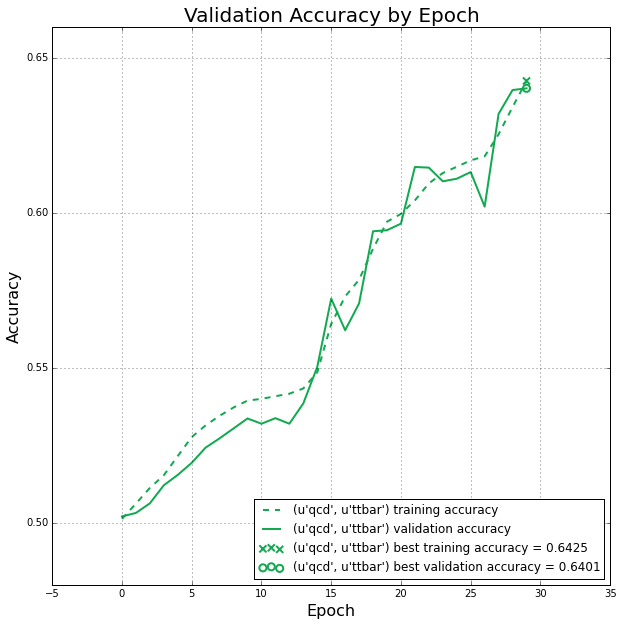

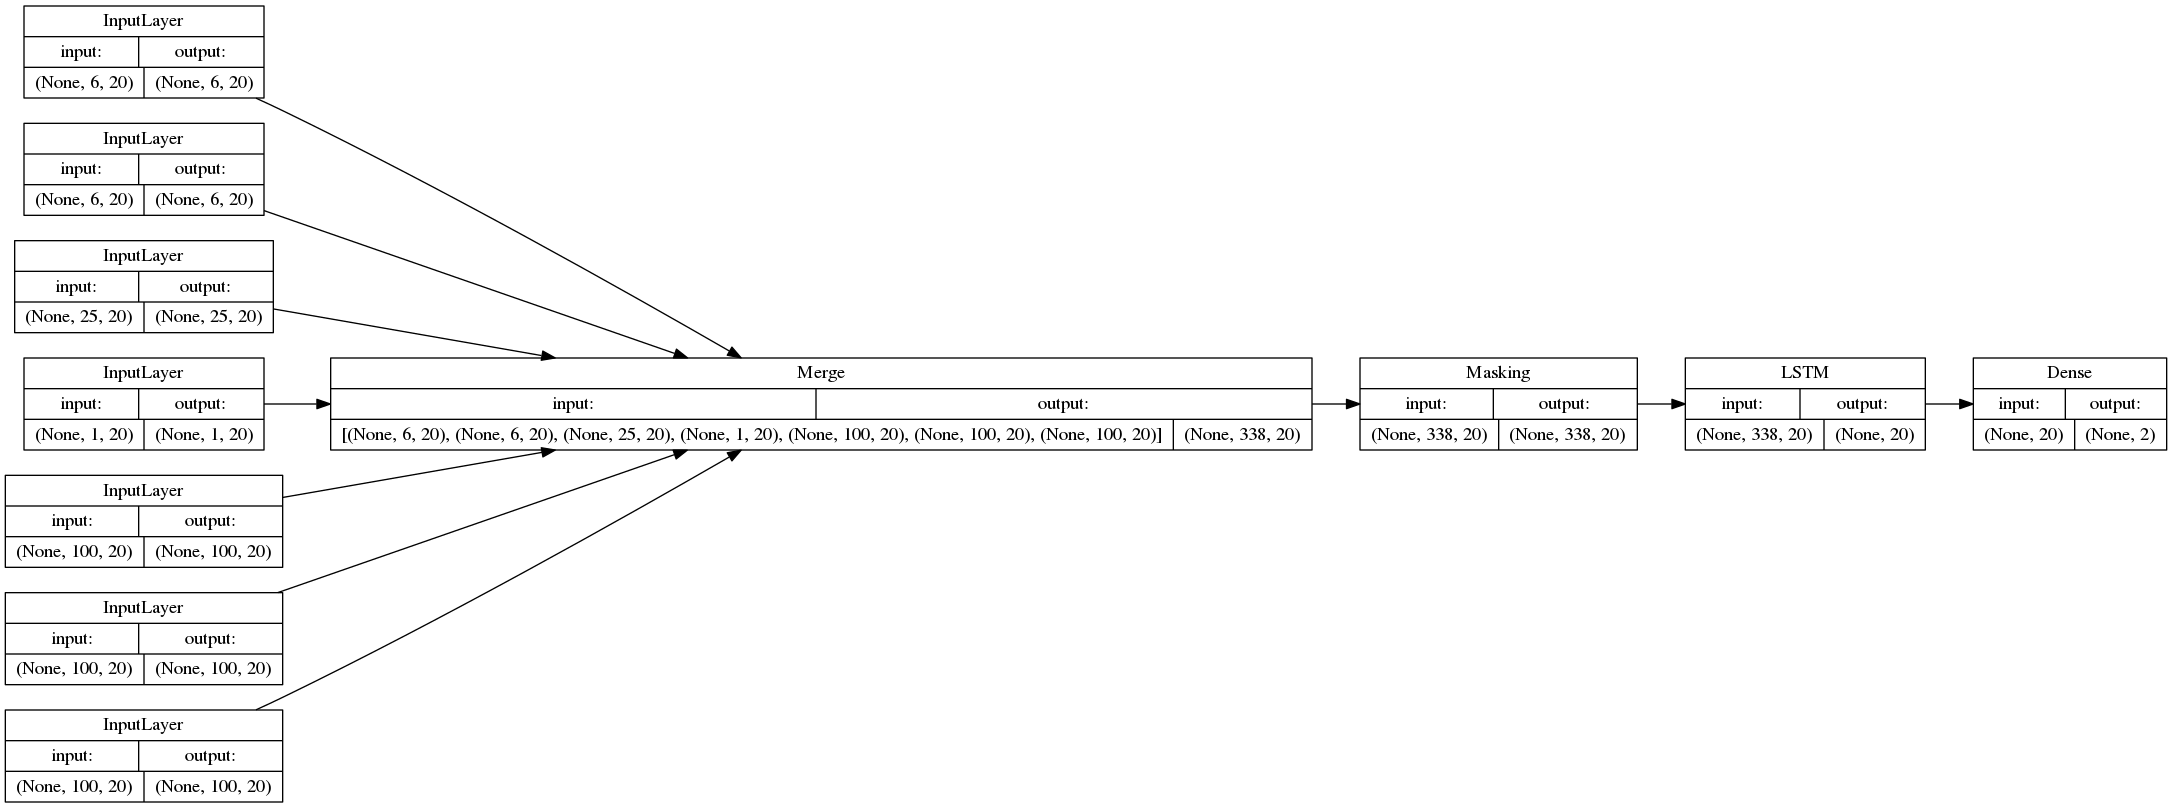

--------------------------------------------------
TRIAL SUMMARY (39599463ce102ca54e56906c5df60c28f8e9bbf3)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 3:41:01, fit_cycles = 1
        test_acc = 0.9813, val_acc = 0.9830, test_loss = 0.0592
        num_train = 150000, num_validation = 40000, num_test = 40000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'qcd', u'wjet'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = Eta, useObjTypeColumn = True, val_acc_ = 0.981139846999, val_acc_error = 0.000667458335243
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


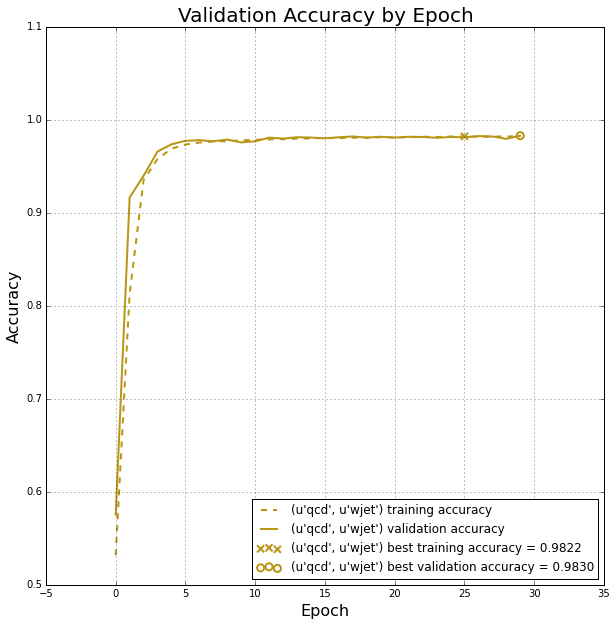

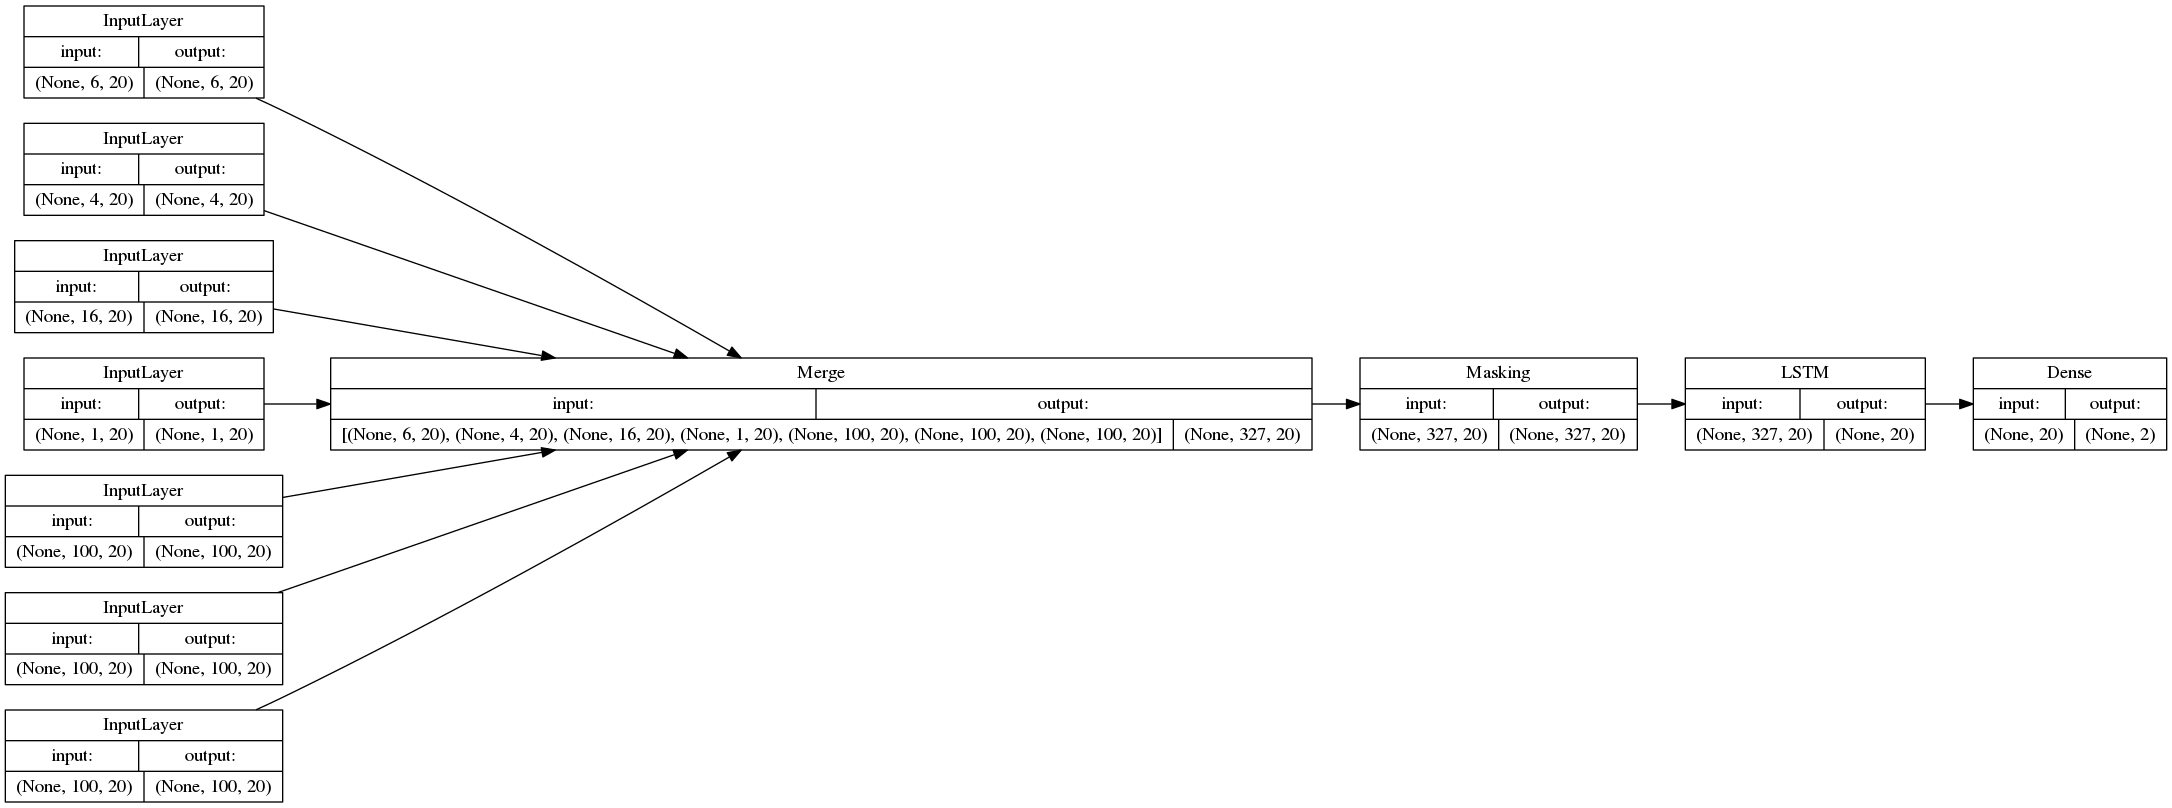

--------------------------------------------------
TRIAL SUMMARY (65315d51324621f55218e3c5de226f88cc06d816)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 2:43:33, fit_cycles = 1
        test_acc = 0.8098, val_acc = 0.8111, test_loss = 0.4242
        num_train = 150000, num_validation = 40000, num_test = 40000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'qcd', u'ttbar'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = Eta, useObjTypeColumn = True, val_acc_ = 0.811140580154, val_acc_error = 0.00195217776329
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


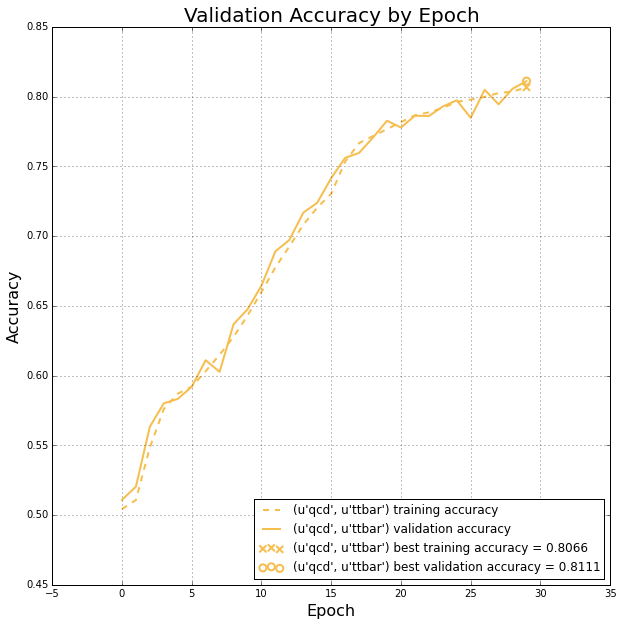

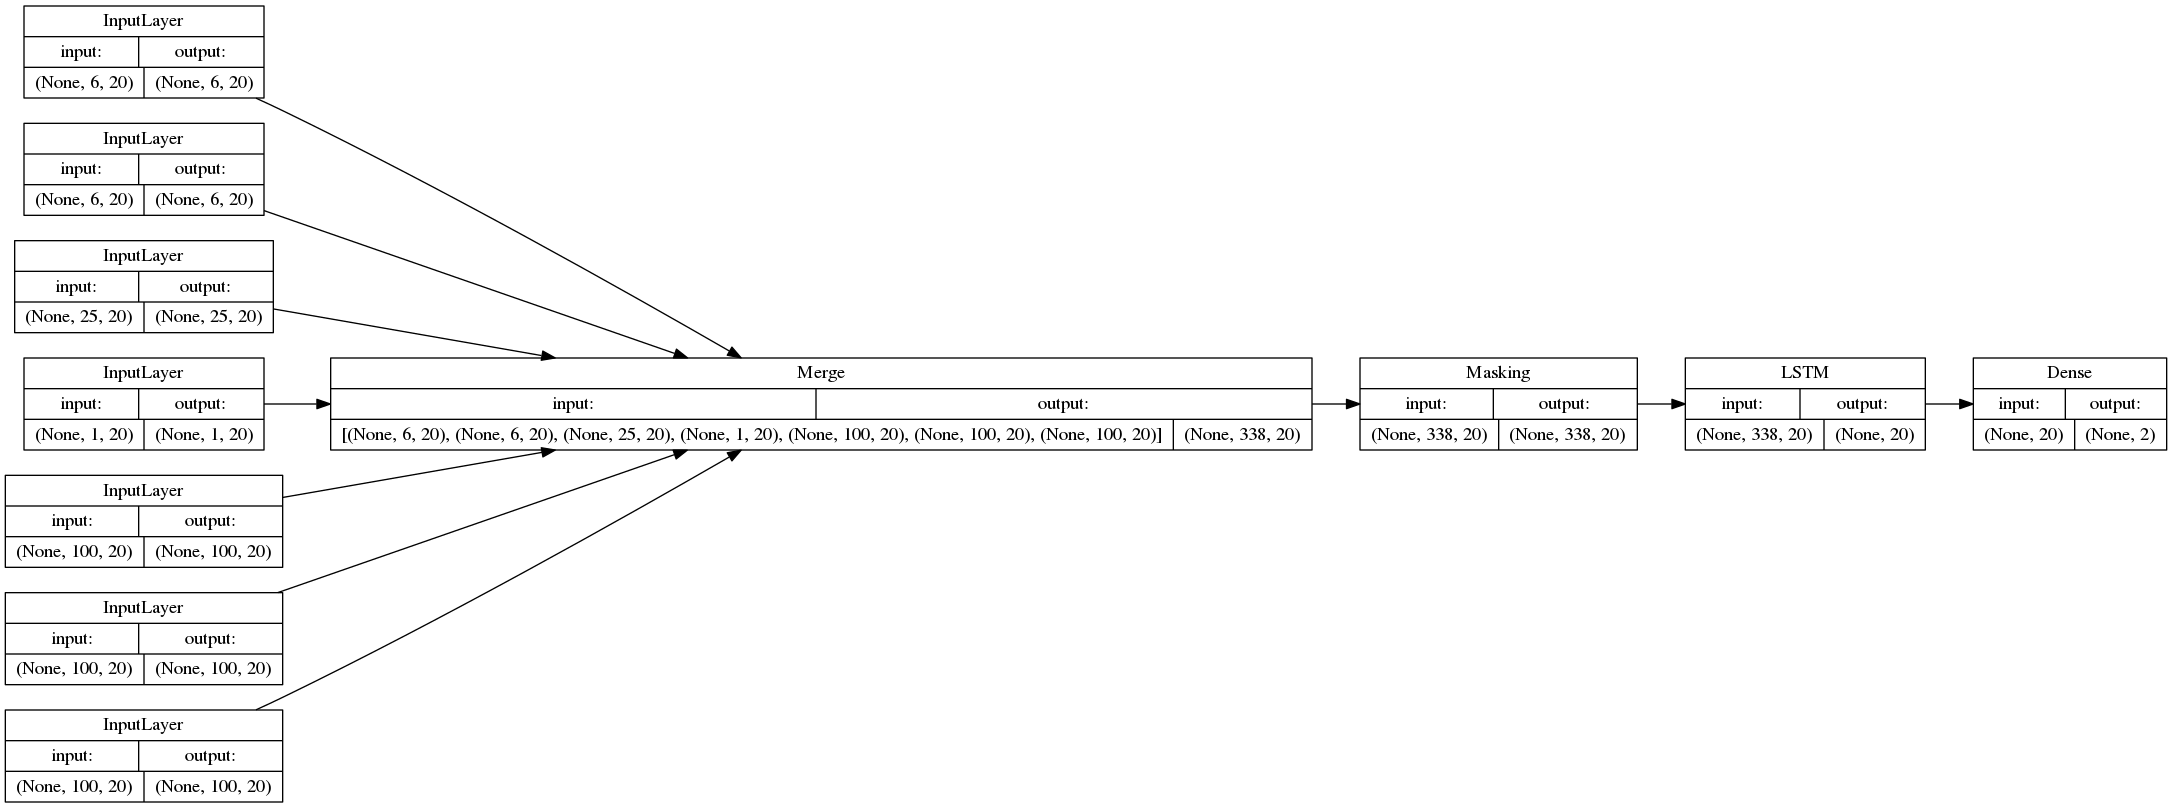

--------------------------------------------------
TRIAL SUMMARY (f838be95c54d193636b5f7ff0d4d5e7f38086ff9)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 4:08:36, fit_cycles = 1
        test_acc = 0.9722, val_acc = 0.9738, test_loss = 0.0815
        num_train = 150000, num_validation = 40000, num_test = 40000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'ttbar', u'wjet'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = Eta, useObjTypeColumn = True, val_acc_error = 0.000766318413492
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


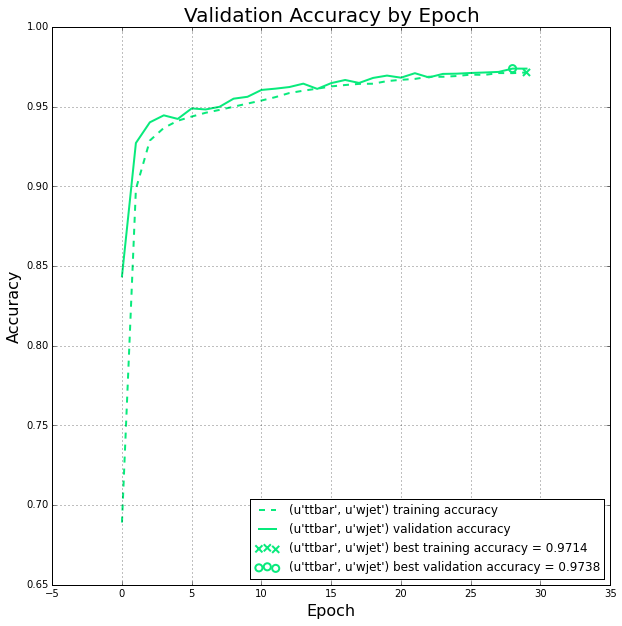

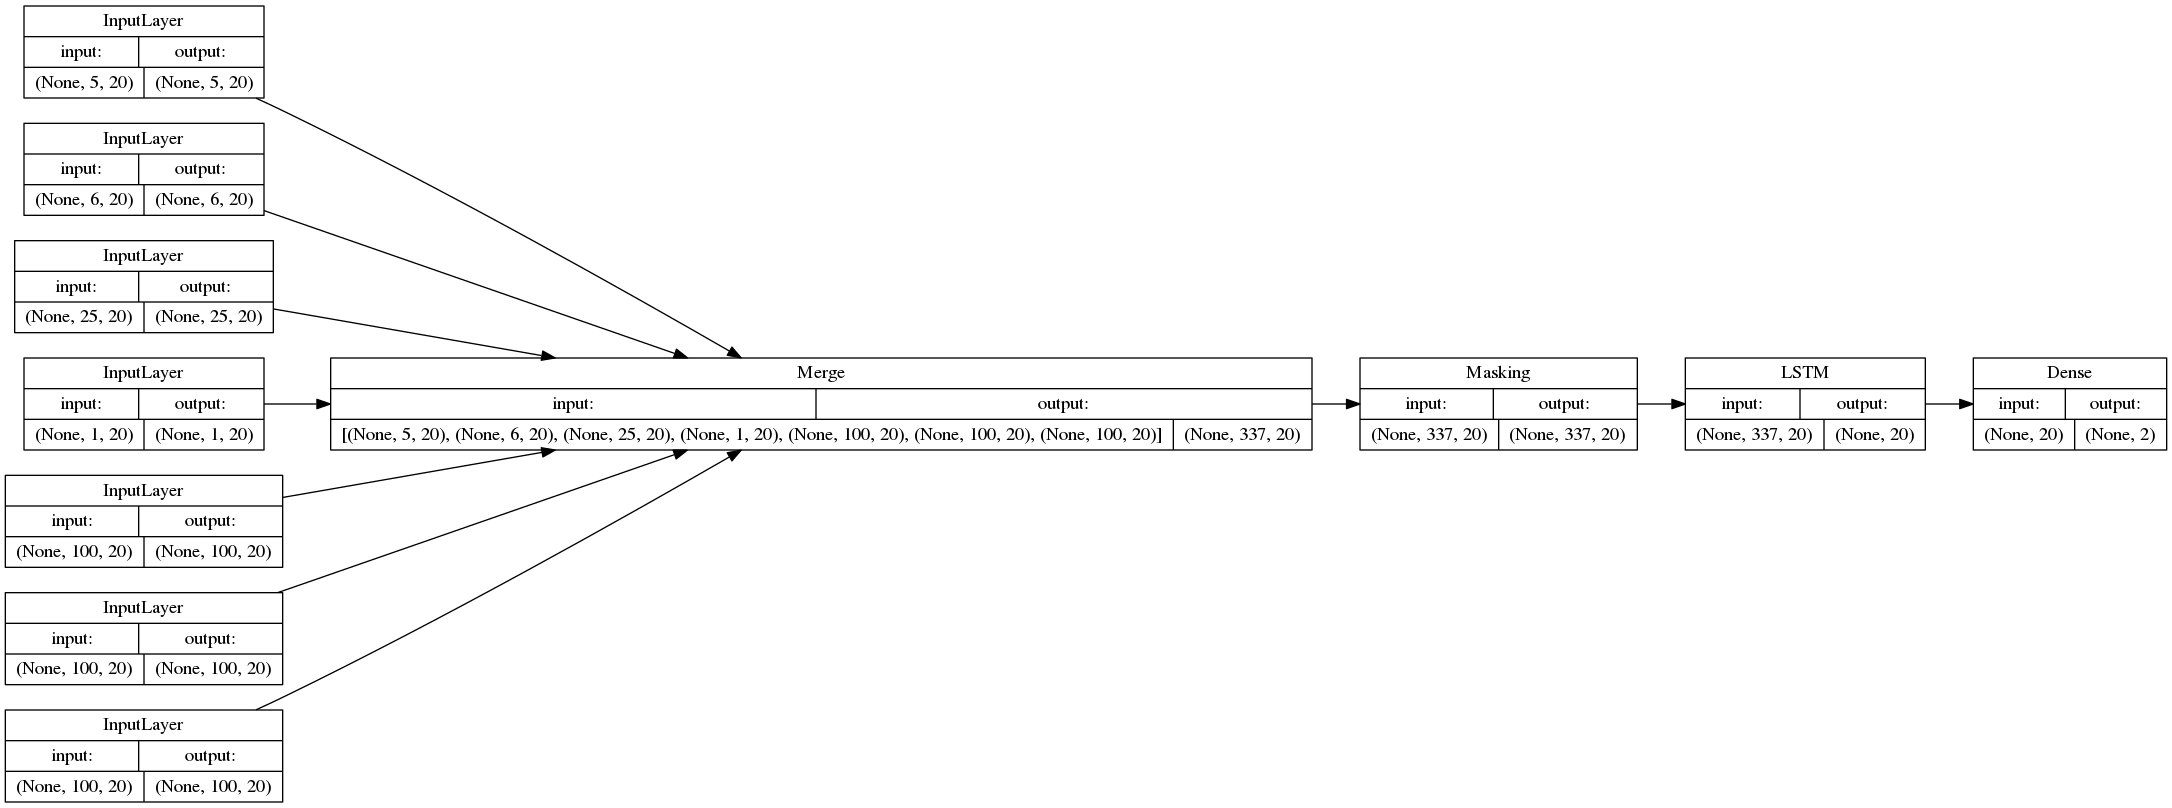

--------------------------------------------------
TRIAL SUMMARY (0442f532ef1454b1c54885ac5a1cd749b404b234)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 4:33:32, fit_cycles = 1
        test_acc = 0.8700, val_acc = 0.8725, test_loss = 0.2793
        num_train = 225000, num_validation = 60000, num_test = 60000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'ttbar', u'wjet', u'qcd'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = PT_ET, useObjTypeColumn = True, val_acc_ = 0.869686171116, val_acc_error = 0.00110438454371
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


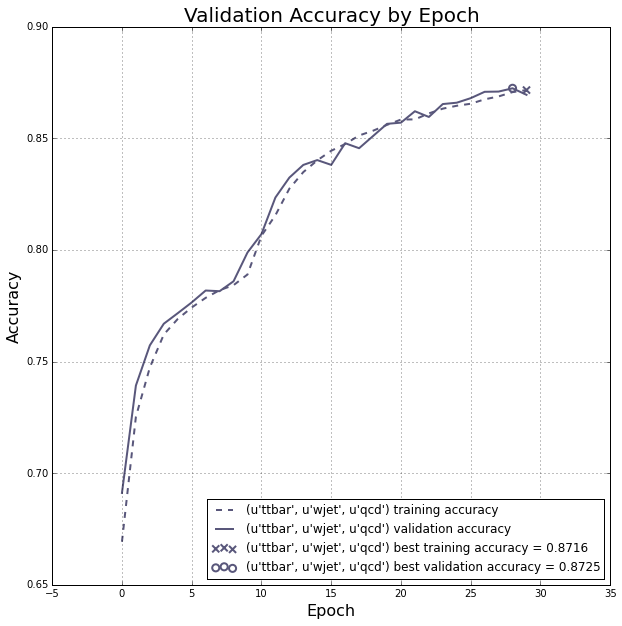

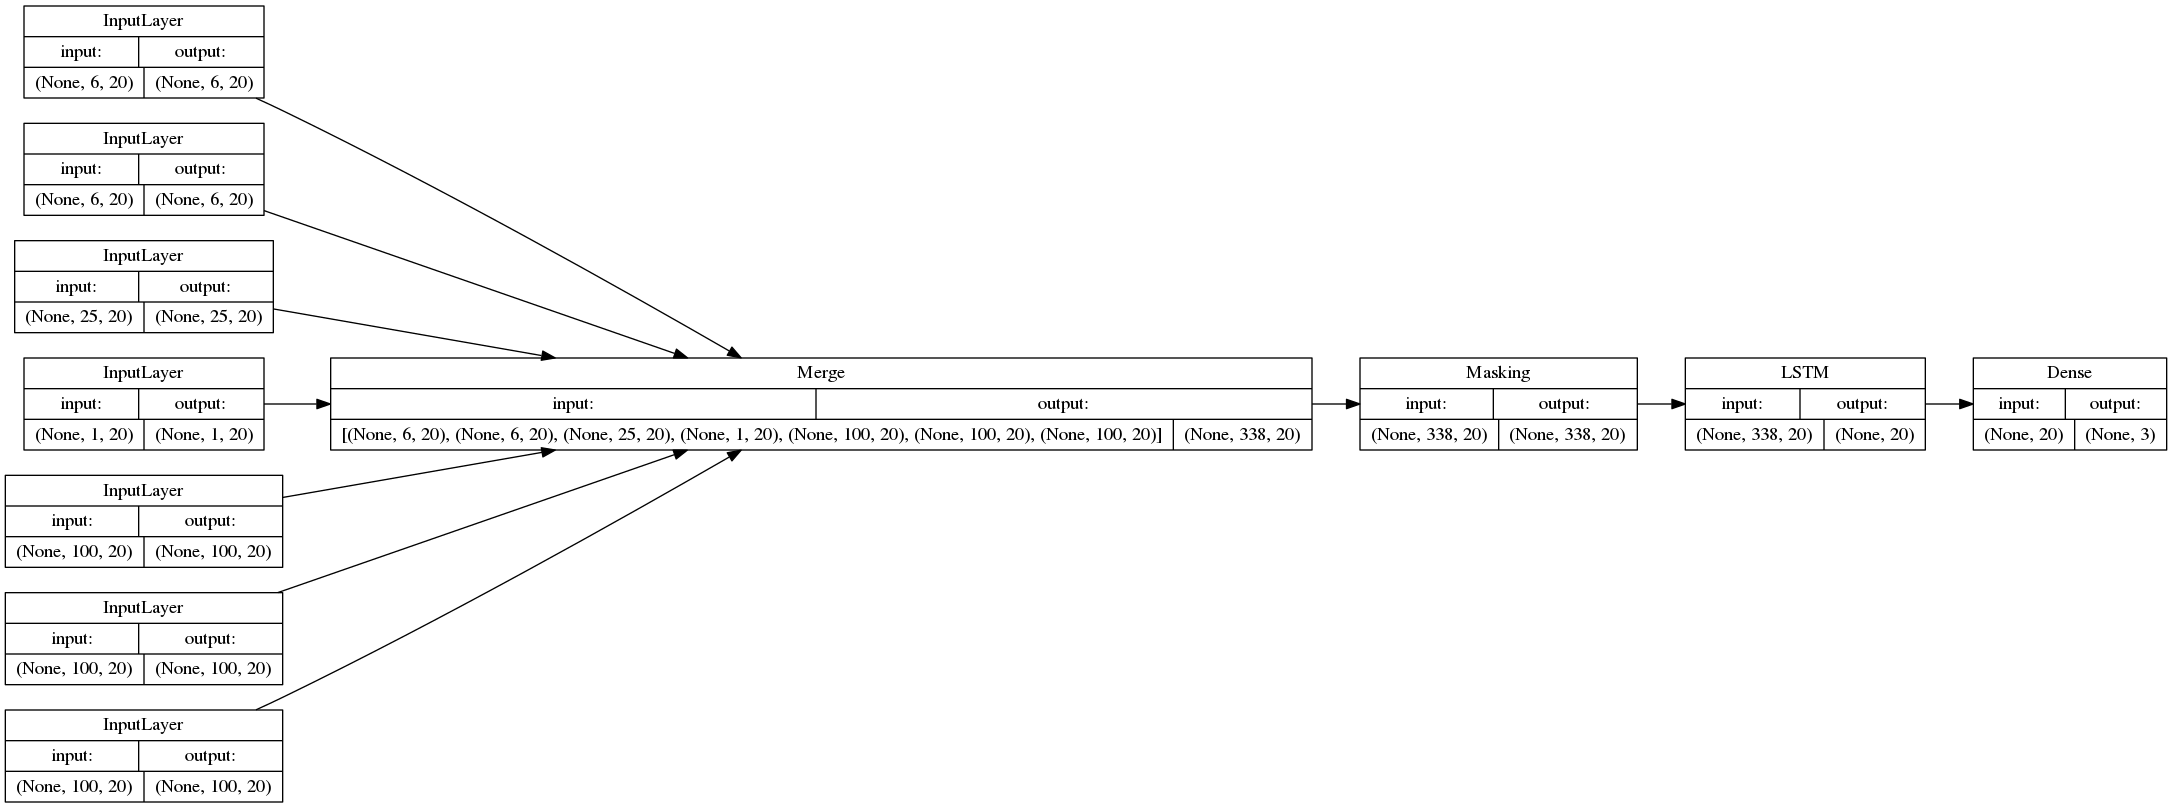

--------------------------------------------------
TRIAL SUMMARY (cccb94e4c5d5963309c722b04e2513185ee21885)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 2:52:45, fit_cycles = 1
        test_acc = 0.9829, val_acc = 0.9831, test_loss = 0.0572
        num_train = 150000, num_validation = 40000, num_test = 40000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'qcd', u'wjet'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = Phi, useObjTypeColumn = True, val_acc_error = 0.000656278479816
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


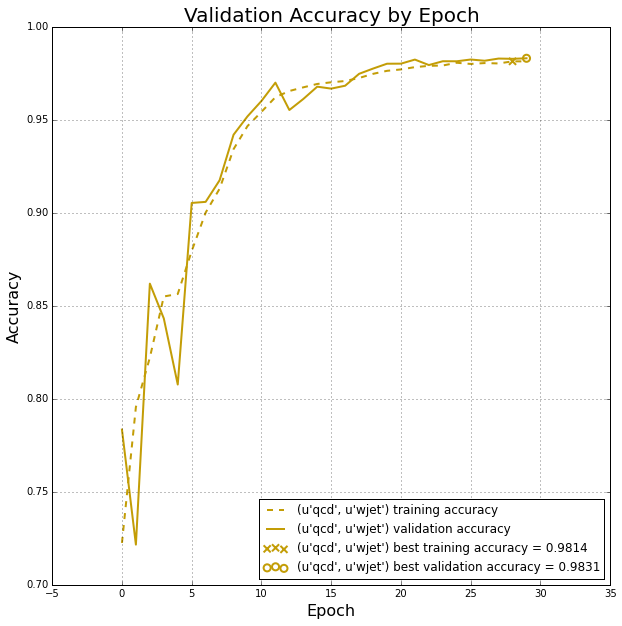

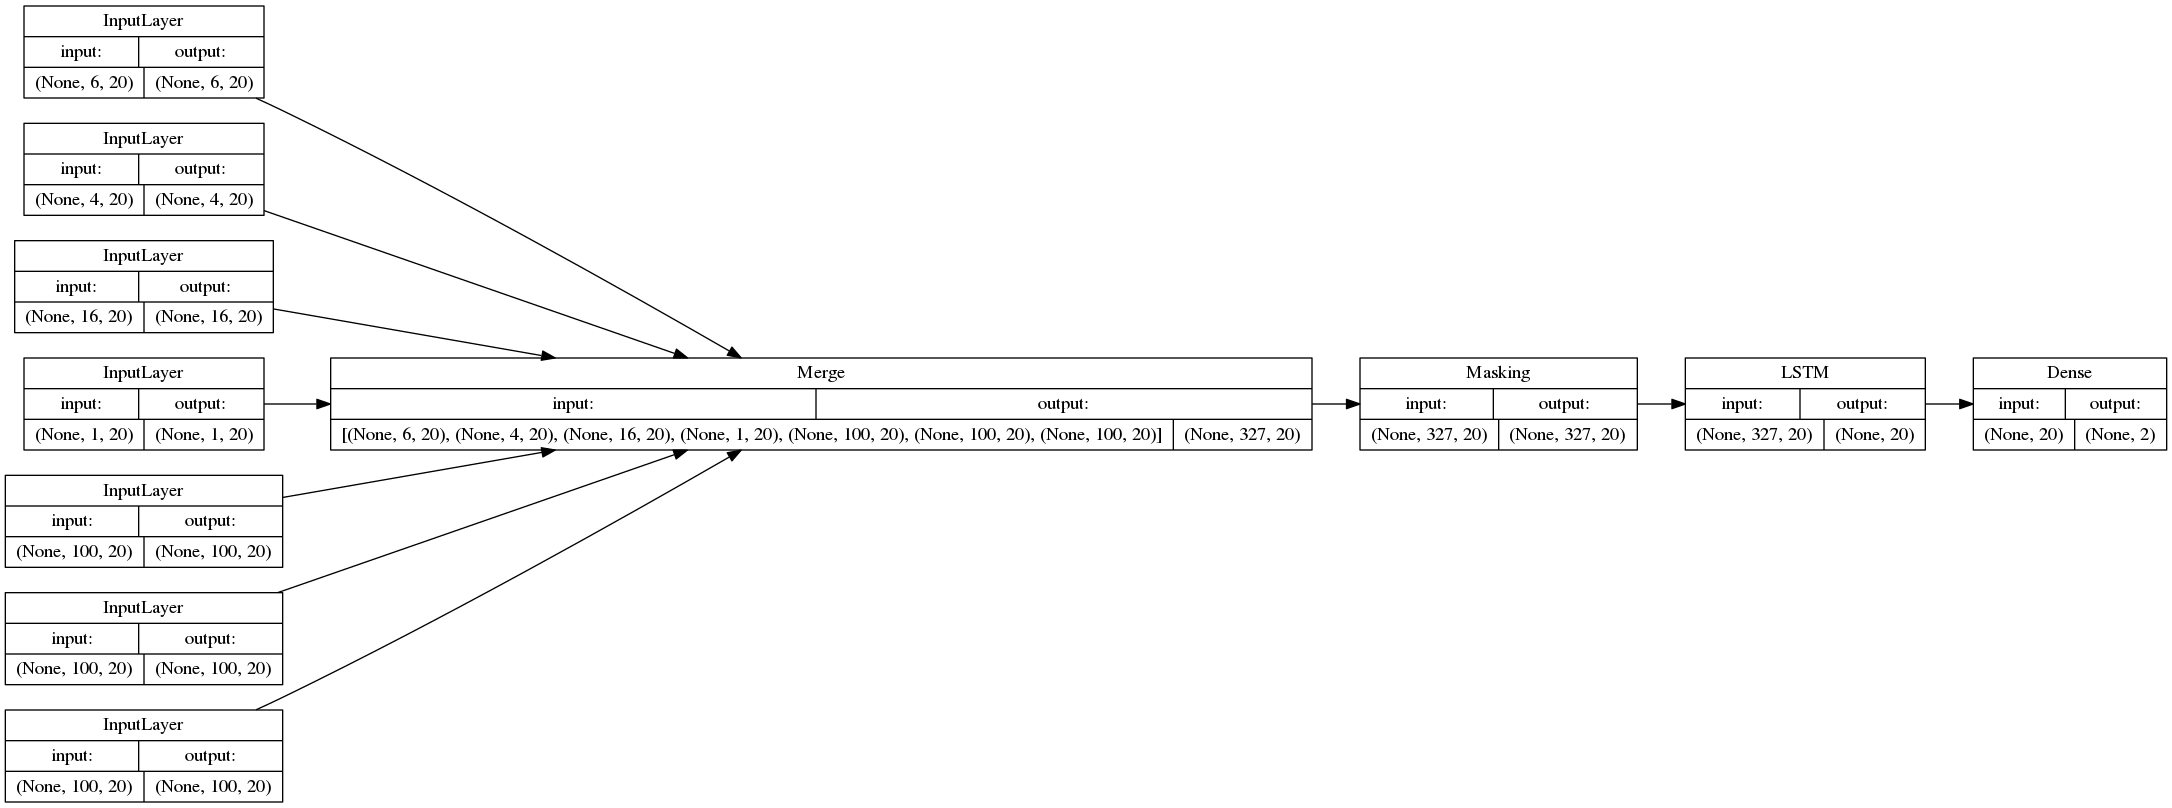

--------------------------------------------------
TRIAL SUMMARY (841e4026eef0dac6dbc849e61d501f05b8c945c2)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 2:40:22, fit_cycles = 1
        test_acc = 0.9747, val_acc = 0.9821, test_loss = 0.0747
        num_train = 150000, num_validation = 40000, num_test = 40000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'qcd', u'wjet'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = PT_ET, useObjTypeColumn = True, val_acc_ = 0.976072327415, val_acc_error = 0.000772752264484
    Fit:
        batch_size=32, nb_epoch=30, callbacks=[{u'patience': 8, u'verbose': 1, u'type': u'EarlyStopping', u'mode': u'auto', u'monitor': u'val_loss'}], validation_split=0.0, shuffle=True, class_weight={}
--------------------------------------------------


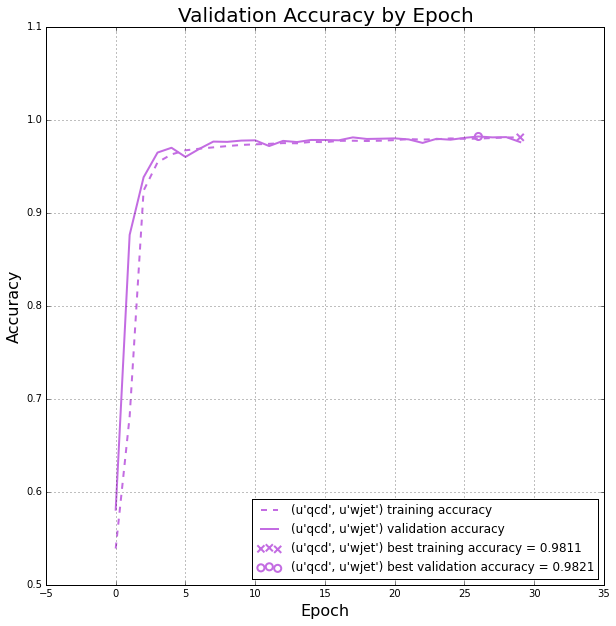

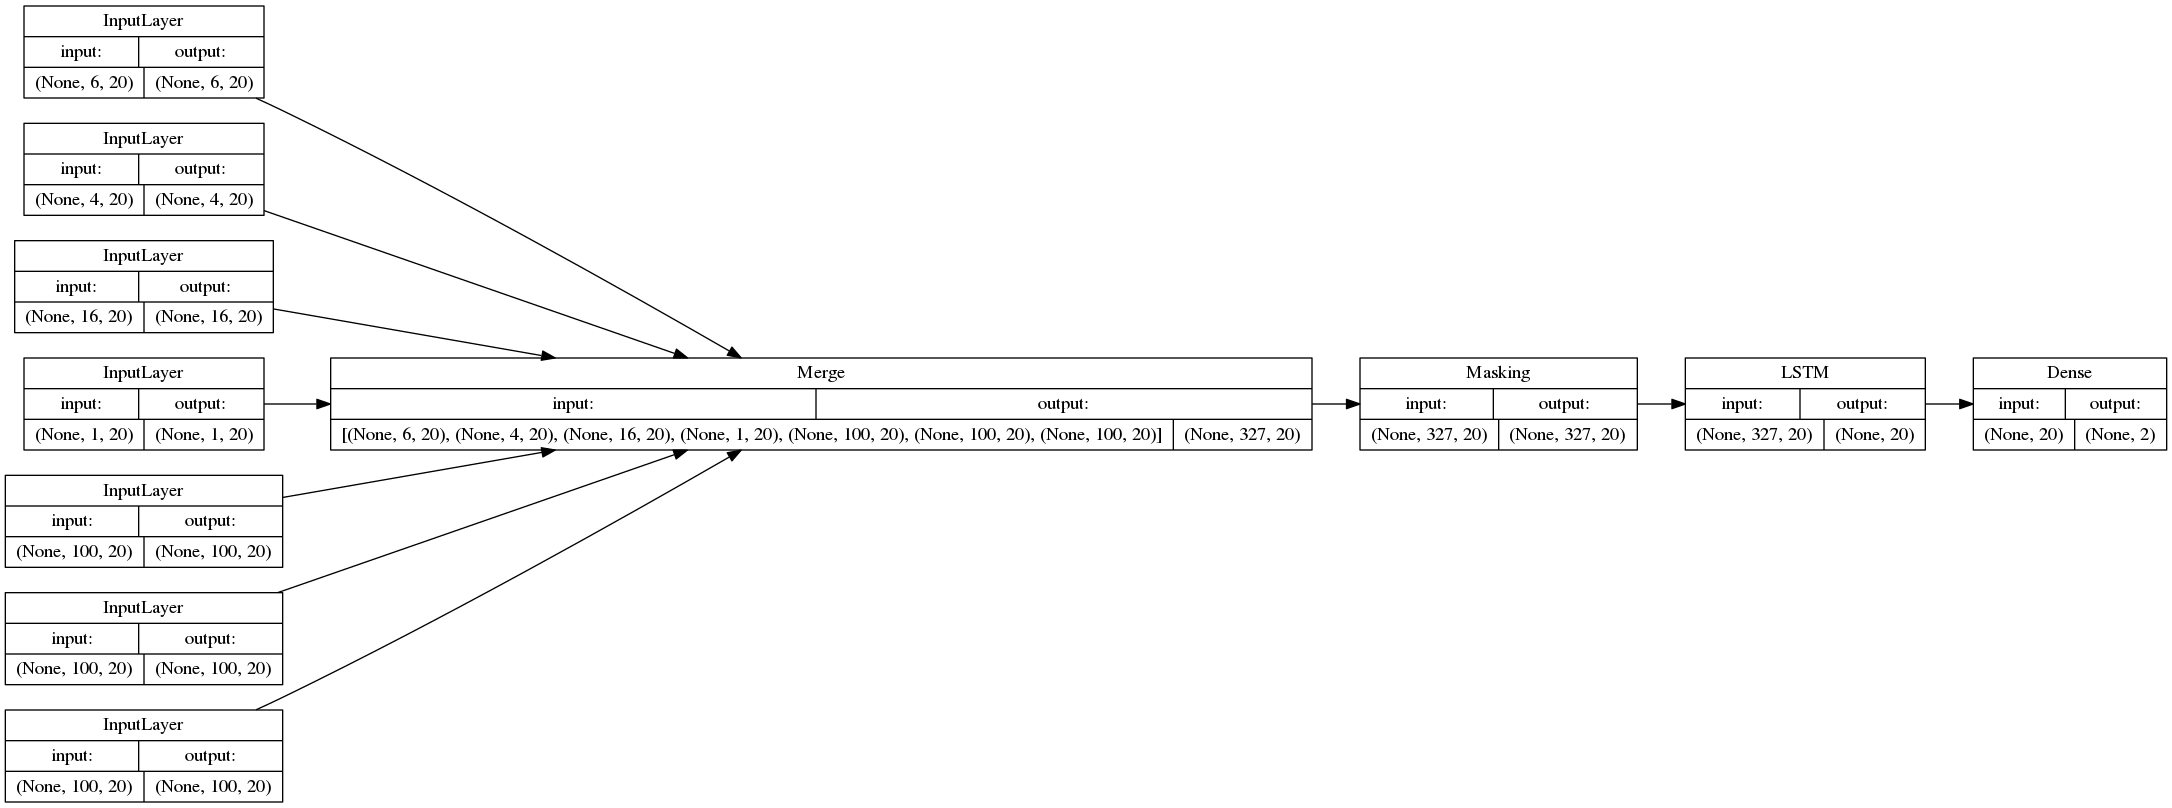

In [4]:
plotEverything(trials)
    
    


In [5]:
phi = findWithMetrics(trials,{"sort_on" : "Phi"})
eta = findWithMetrics(trials,{"sort_on" : "Eta"})
PT = findWithMetrics(trials,{"sort_on" : "PT_ET"})
sortOnMetric(phi, "labels")
sortOnMetric(eta, "labels")
sortOnMetric(PT, "labels")
labelGroups = zip(phi,eta,PT)

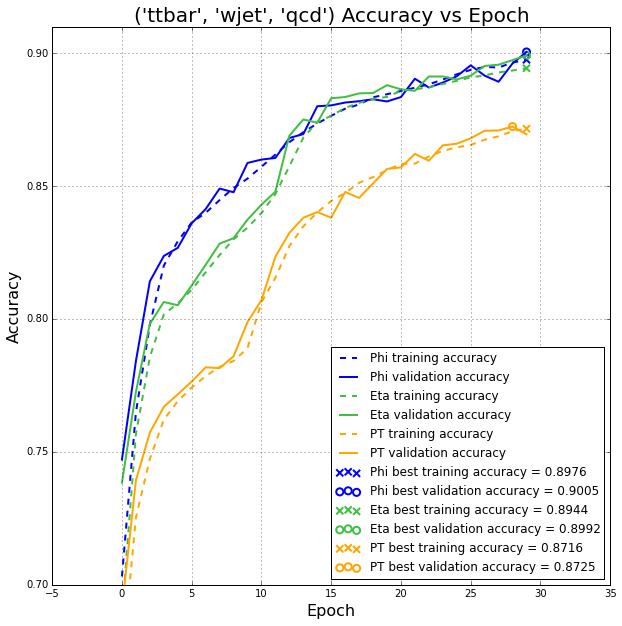

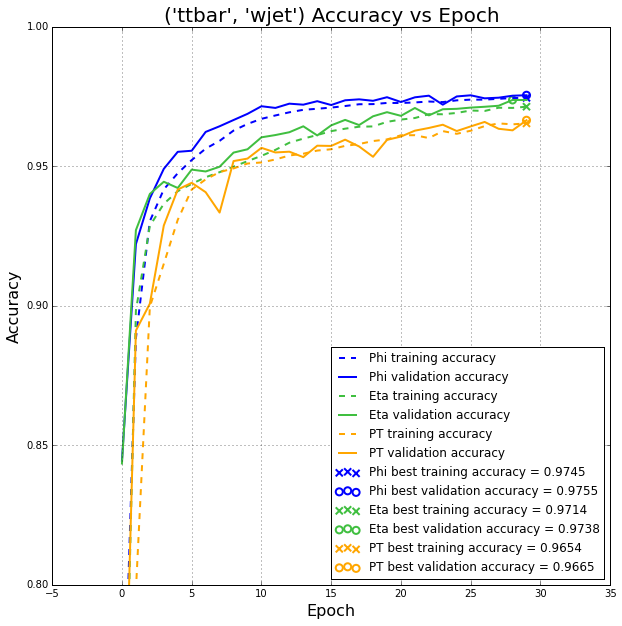

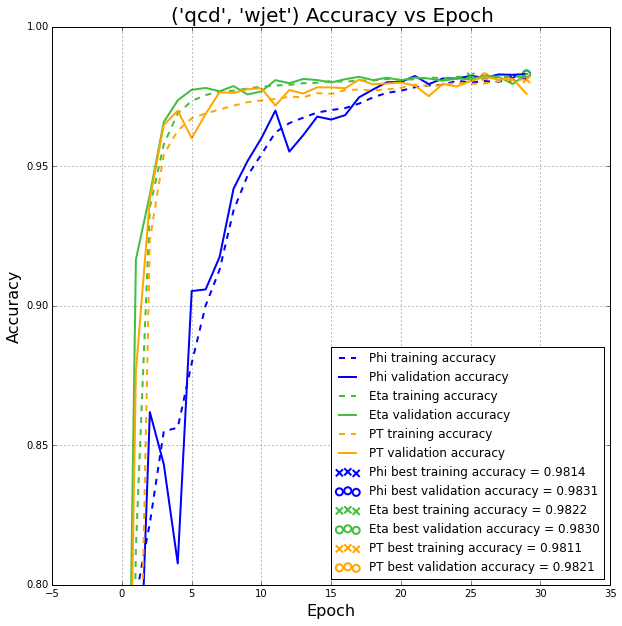

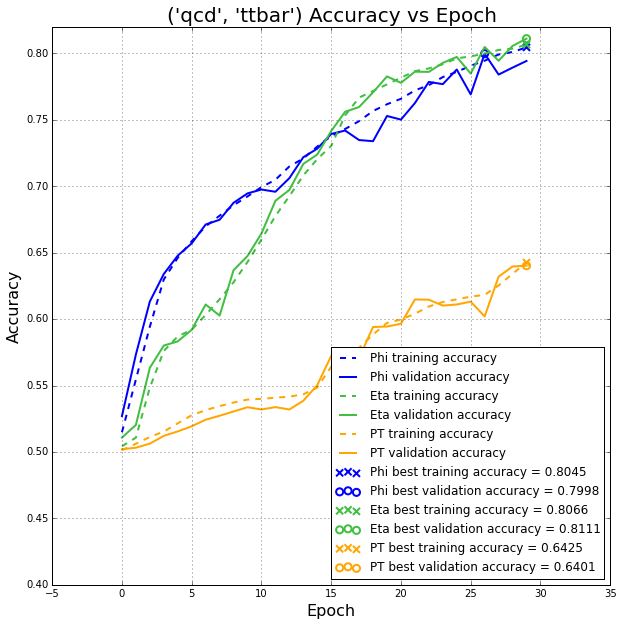

In [6]:
colors = [(0,0,1.0),(.25,.75,.25), (1,.65,0)]
names = ["Phi", "Eta","PT"]
lims = [[.7,.91], [.8,1.0],  [.8,1.0],  [.4,.82]]
for j , tup in enumerate(labelGroups):
    plots = []
    for i, b in enumerate(tup):
        labels = b.get_from_record("labels")
        if(labels == None): labels = b.get_from_record("lables")
        title = str(tuple([str(x) for x in labels])) if(labels != None) else "Cannot Find Labels"
        title = title + " Accuracy vs Epoch"
        name = names[i]
        model = b.get_model(custom_objects={"Slice":Slice, "Lorentz" : Lorentz})
        history = b.get_history()
        color = colors[i]
        plots.append((name, history, color))
    plot_history(plots, plotLoss=False, title=title, acclims=lims[j])
    
    

In [7]:
data = np.zeros(( len(labelGroups[0]),len(labelGroups) ) ).tolist()
print(data)
columns = [None] * len(labelGroups)
rows = [" "+ n + " " for n in names]

for j , tup in enumerate(labelGroups):
    for i, b in enumerate(tup):
        labels = b.get_from_record("labels")
        columns[j] = str(tuple([str(x) for x in labels]))
        error = getError(b,custom_objects={"Slice":Slice, "Lorentz" : Lorentz}, ignoreAssert=True)
        d = "%.5f %s %.5f" % (b.get_from_record("val_acc"),unichr(177), error)
        data[i][j] = d
        
        
#print(data)
        

[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]


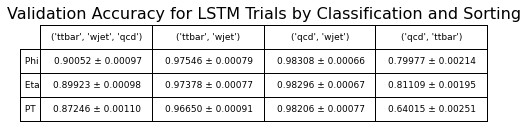

In [8]:
plotTable(rows, columns, data,scale=2, title="Validation Accuracy for LSTM Trials by Classification and Sorting")

In [56]:
def getTrialBins(trial, bins=20):
    trial.summary()
    d = accVsEventChar(trial, None, np.sum, "PT_ET", ["EFlowPhoton","EFlowNeutralHadron","EFlowTrack"],
                       bins=bins,custom_objects={"Slice": Slice, "Lorentz": Lorentz},equalBins=False)
    #plotBins(d,title='Accuracy vs Sum of PF Candidate PT', xlabel="PT GeV", ylabel='Accuracy', color=(0.553,0.188,0.38))
    return d
eta_bins = [getTrialBins(t,40) for t in eta]
phi_bins = [getTrialBins(t,40) for t in phi]

--------------------------------------------------
TRIAL SUMMARY (40ba6f6c372697218128b9493834451ae739bf3c)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 4:13:20, fit_cycles = 1
        test_acc = 0.8992, val_acc = 0.8992, test_loss = 0.2320
        num_train = 225000, num_validation = 60000, num_test = 60000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'ttbar', u'wjet', u'qcd'], lstm_dropout = 0.0, patience = 8, query = PT_ET > 1.0, sort_on = Eta, useObjTypeColumn = True, val_acc_error = 0.000979855942508
--------------------------------------------------
--------------------------------------------------
TRIAL SUMMARY (f838be95c54d193636b5f7ff0d4d5e7f38086ff9)
    Record_Info:
        name = [u'trial', u'LSTM'], elapse_time = 4:08:36, fit_cycles = 1
        test_acc = 0.9722, val_acc = 0.9738, test_loss = 0.0815
        num_train = 150000, num_validation = 40000, num_test = 40000
        activation = tanh, depth = 1, dropout = 0.0, labels = [u'

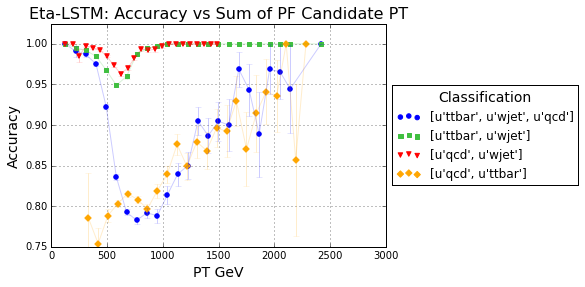

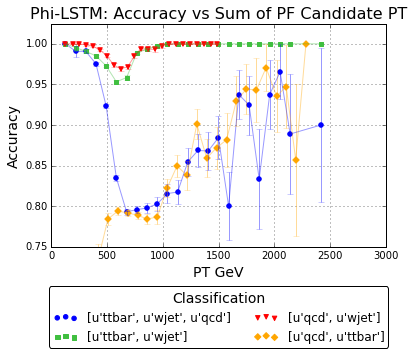

In [59]:
colors = [(0,0,1.0),(.25,.75,.25), (1,0,0), (1,.65,0)]
lables = [trial.get_from_record("labels") for trial in eta]
plotBins(eta_bins,mode="scatter",title='Eta-LSTM: Accuracy vs Sum of PF Candidate PT',binLabels=lables, xlabel="PT GeV", ylabel='Accuracy',
         legendTitle="Classification",colors=colors, alpha=.2, ylim=(0.75, 1.025), xlim=(0,3000))

lables = [trial.get_from_record("labels") for trial in phi]
plotBins(phi_bins,mode="scatter",title='Phi-LSTM: Accuracy vs Sum of PF Candidate PT',binLabels=lables, xlabel="PT GeV", ylabel='Accuracy',
         legendTitle="Classification",legendBelow=True,colors=colors, alpha=.4, ylim=(0.75, 1.025), xlim=(0,3000))